In [161]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [162]:
import numpy as np
import mne
import os
import sys
from mne.datasets import eegbci
import matplotlib.pyplot as plt
from scipy import signal
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
mne.set_log_level('WARNING')

## EEG Motor Movement/Imagery Dataset

1. https://www.physionet.org/content/eegmmidb/1.0.0/
2. Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. IEEE Transactions on Biomedical Engineering 51(6):1034-1043, 2004
3. https://mne.tools/stable/auto_examples/index.html

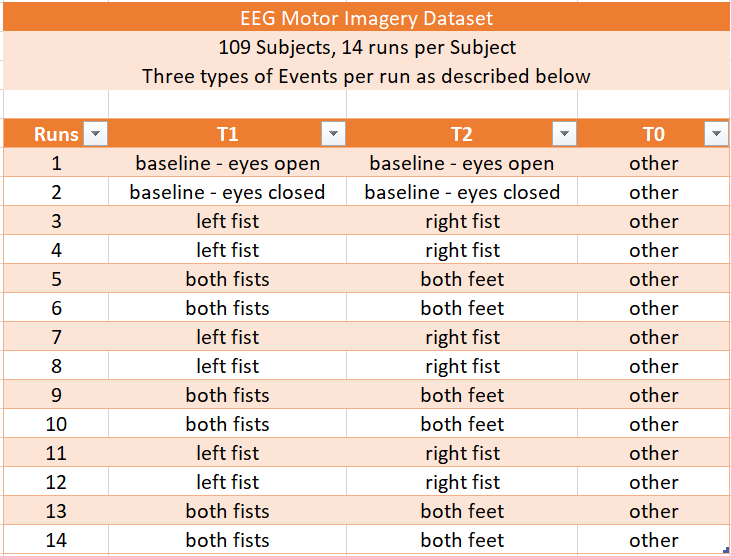

### Defining a motorImagery class for Data Loading and Pre-processing

In [163]:
class motorImagery:
    def __init__(self, path=None, subjects=[1], runs=[1]):
        self.path = path
        self.edf_filenames = self.get_filenames(path)
        self.raw = self.load_eeg(subjects, runs)
        
    def get_filenames(self, path):
        file = open(dataset_path+'RECORDS')
        edf_filenames = file.readlines()
        file.close()
        edf_filenames = [fname.rstrip() for fname in edf_filenames]
        return edf_filenames
    
    def load_eeg(self, subjects, runs):    #load -> standardize -> notch_filter -> bandpass filter -> return
    
        fno = self.get_fileIndices(subjects, runs)
        print('Loading files at index:', fno)
        
        raw_eegs = []
        for idx,i in enumerate(fno):
            path_file = os.path.join(self.path, self.edf_filenames[i])
            sys.stdout.write(f"\rLoading file #{idx+1}/{len(fno)}: {path_file}")
            raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
            raw_eegs.append(raw)

        raw = mne.io.concatenate_raws(raw_eegs)     # Concatenate all EEGs together
        eegbci.standardize(raw)                     # Standardize channel names
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        return raw                                  
    
    def get_fileIndices(self, subjects, runs):
        fno = []
        subjects = [s-1 for s in subjects]  # start from 0, 1, 2, ...
        for subject in subjects:
            for run in runs:
                fno.append(subject*14+run-1)   # 14 runs per subject
        return fno
    
    def apply_filter(self, freq):
        # Remove power line noise atrifacts at 50 Hz <-- European data so 50Hz powerline freq
        #self.raw.notch_filter(50)
        # Remove higher frequencies as they are redundant for analysis.
        low_freq, high_freq = freq
        self.raw.filter(low_freq, high_freq, fir_design='firwin')
        
    def get_ica(self, n=16):
        self.ica = mne.preprocessing.ICA(n_components=n, max_iter='auto', random_state=97)
        self.ica.fit(self.raw)
        self.raw.load_data()
        self.ica.plot_sources(self.raw)
        self.ica.plot_components()
        
    def exclude_ic(self, channels):
        self.ica.exclude = channels
        self.ica.apply(self.raw)

    def get_events(self):
        event_id = dict(T1=2, T2=3)        # Define the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        # We don't need it for now but lets include it as it is a part of the pipeline of eeg classification
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')

        # tmin and tmax are relative to the event onset time. They decide the time interval (relative to event onset) taken to 
        # form the epoch from eeg signal. 
        tmin = -1  # A second before event cue 
        tmax = 4   # Four seconds after cue. Most events are of 4.1 or 4.2 seconds long as described in annotations.

        # Read epochs (only the events described in our event_id will be included for training)
        # For future try to use baseline subtraction method 
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=False, 
                            picks=picks, baseline=None, preload=True)

        # Only eeg signals in time interval 1-2 sec will be used for training -> 1 sec after event cue to 2 sec after cue.
        # This is to avoid the evoked potentials arising in brain in response to event cue.
        epochs_train = epochs.copy().crop(tmin=0., tmax=4.)
        montage = mne.channels.make_standard_montage('standard_1005')
        epochs_train.set_montage(montage)
        
        return epochs_train
    
    def downsample(self, epochs, factor):
        return epochs.decimate(factor)
        
    def return_epochs(self, freq=(1, 35), dsamplingFactor=1, channel_selection=False, channels=None):
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        self.epochs = self.downsample(self.epochs, dsamplingFactor)
        self.labels = self.epochs.events[:,-1] - 2        # Convert from 2,3 to 0,1 and assign to labels for training
        if channel_selection:
            if channels is None:
                self.epochs = self.epochs.pick_channels(self.epochs.ch_names[:21])
            else:
                self.epochs = self.epochs.pick_channels(channels)
        return self.epochs, self.labels
    
    def get_X_y(self, channel_selection=False, channels=None):
        self.return_epochs(channel_selection=channel_selection, channels=channels)
        return self.epochs.get_data(), self.labels

#### Loading data using the motorImagery class

In [165]:
dataset_path = os.path.join("H:\\","BCI Project","eeg-motor-movementimagery-dataset-1.0.0","files\\")
subjects = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
runs = [6,10,14]
eeg = motorImagery(dataset_path, subjects, runs)

#eeg.apply_filter(freq=(7,30))
#X, y = eeg.get_X_y()
#X.shape

Loading files at index: [5, 9, 13, 19, 23, 27, 33, 37, 41, 47, 51, 55, 61, 65, 69, 75, 79, 83, 89, 93, 97, 103, 107, 111, 117, 121, 125, 131, 135, 139, 145, 149, 153, 159, 163, 167, 173, 177, 181, 187, 191, 195, 201, 205, 209, 215, 219, 223, 229, 233, 237, 243, 247, 251, 257, 261, 265, 271, 275, 279]
Loading file #60/60: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S020/S020R14.edf

MemoryError: Unable to allocate 578. MiB for an array with shape (64, 1183680) and data type float64

In [126]:
eeg.raw.annotations.description.shape

(478,)

In [137]:
eeg.raw.annotations.description

array(['T0', 'T2', 'T0', 'T1', 'T0', 'T1', 'T0', 'T2', 'T0', 'T1', 'T0',
       'T2', 'T0', 'T2', 'T0', 'T1', 'T0', 'T1', 'T0', 'T2', 'T0', 'T2',
       'T0', 'T1', 'T0', 'T1', 'T0', 'T2', 'T0', 'T2', 'BAD boundary',
       'EDGE boundary', 'T0', 'T1', 'T0', 'T2', 'T0', 'T2', 'T0', 'T1',
       'T0', 'T2', 'T0', 'T1', 'T0', 'T1', 'T0', 'T2', 'T0', 'T2', 'T0',
       'T1', 'T0', 'T1', 'T0', 'T2', 'T0', 'T2', 'T0', 'T1', 'T0', 'T2',
       'BAD boundary', 'EDGE boundary', 'T0', 'T2', 'T0', 'T1', 'T0',
       'T2', 'T0', 'T1', 'T0', 'T1', 'T0', 'T2', 'T0', 'T1', 'T0', 'T2',
       'T0', 'T1', 'T0', 'T2', 'T0', 'T2', 'T0', 'T1', 'T0', 'T2', 'T0',
       'T1', 'T0', 'T2', 'BAD boundary', 'EDGE boundary', 'T0', 'T1',
       'T0', 'T2', 'T0', 'T2', 'T0', 'T1', 'T0', 'T2', 'T0', 'T1', 'T0',
       'T2', 'T0', 'T1', 'T0', 'T2', 'T0', 'T1', 'T0', 'T1', 'T0', 'T2',
       'T0', 'T2', 'T0', 'T1', 'T0', 'T1', 'BAD boundary',
       'EDGE boundary', 'T0', 'T2', 'T0', 'T1', 'T0', 'T2', 'T0', 'T1',
  

In [122]:
mne.Epochs?

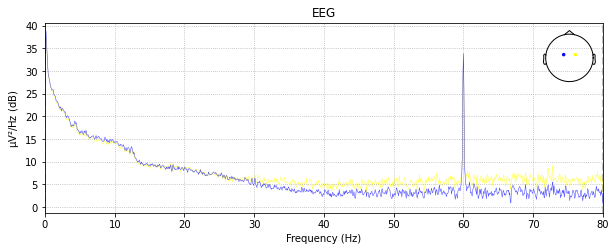

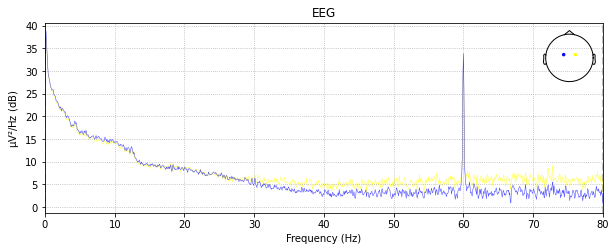

In [159]:
eeg.raw.plot_psd(picks=['C1', 'C2'])

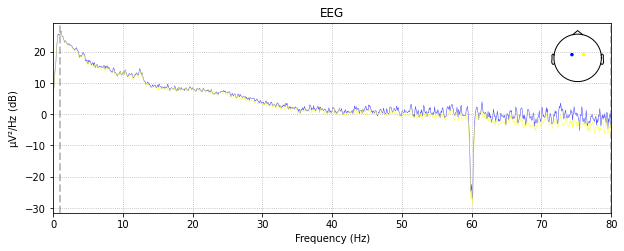

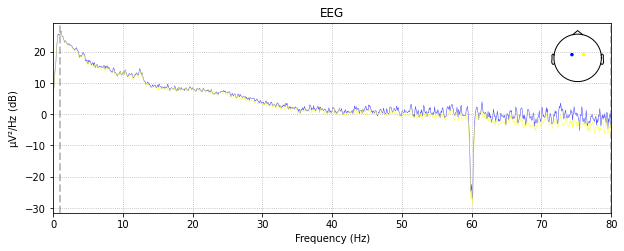

In [127]:
raw = eeg.raw.copy()
raw.notch_filter(60, filter_length='auto', phase='zero')
raw.filter(l_freq=1, h_freq=None)
raw.plot_psd(picks=['C1', 'C2'])

In [128]:
ica = mne.preprocessing.ICA(n_components=16, random_state=42)
ica.fit(raw)

C:\Users\DELL\AppData\Local\Temp/ipykernel_8104/185973250.py:1: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=16, random_state=42)


<ICA | raw data decomposition, fit (fastica): 297120 samples, 16 components, channels used: "eeg">

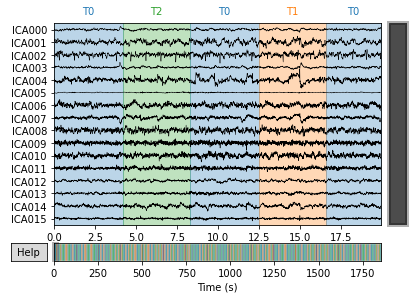

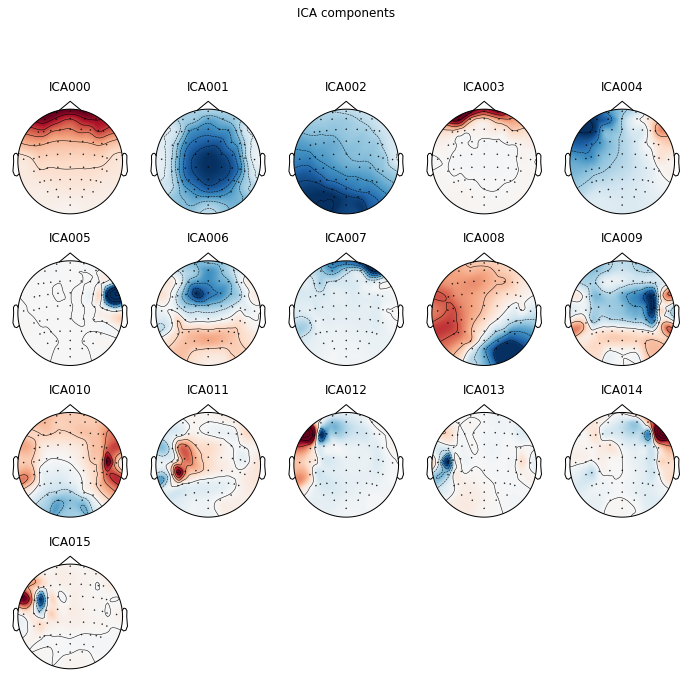

[<MNEFigure size 702x696.24 with 16 Axes>]

In [131]:
ica.plot_sources(raw)
ica.plot_components()

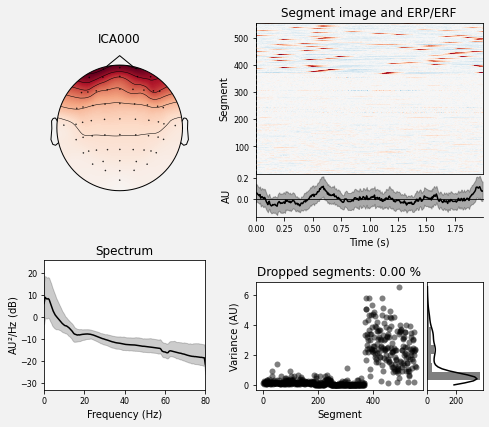

[<Figure size 504x432 with 6 Axes>]

In [75]:
ica.plot_properties(raw, picks=[0])

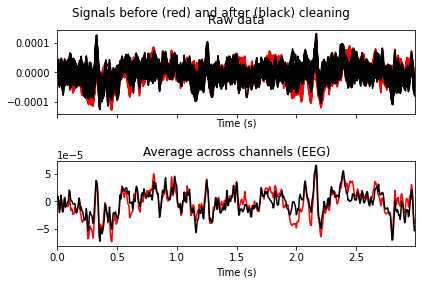

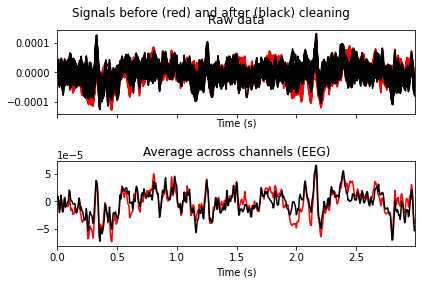

In [76]:
ica.plot_overlay(raw, exclude=[0])

In [129]:
ica.exclude = [0,1]
ica.apply(eeg.raw)
del raw

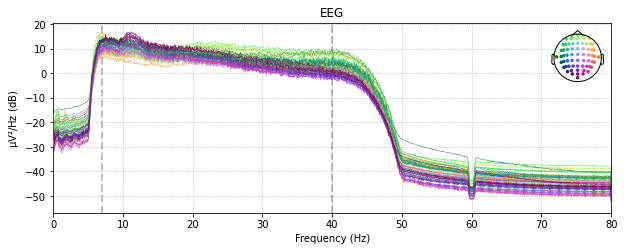

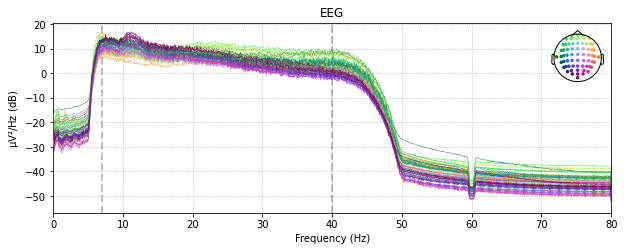

In [130]:
eeg.apply_filter(freq=(7,40))
eeg.raw.notch_filter(60)
eeg.raw.plot_psd()

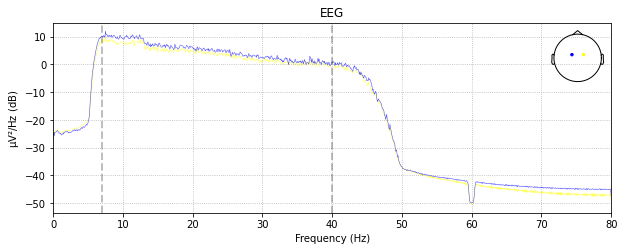

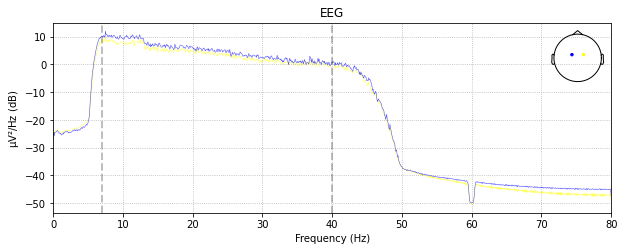

In [131]:
eeg.raw.plot_psd(picks=['C1','C2'])

In [132]:
X, y = eeg.get_X_y(channel_selection=True, channels=['C1', 'C2'])
X.shape

(225, 2, 641)

### CNN + Raw + Channel Selection

In [48]:
X.shape

(225, 2, 641)

In [138]:
X_norm = (X-X.mean(axis=0))/X.std(axis=0)
X_norm.shape

(225, 2, 641)

#### Reshape X to (batch, time series, electrode_channel) - With Normalization

In [139]:
xin = X_norm.transpose(0, 2, 1)
xin = xin[:, np.newaxis, :, :]
xin = torch.FloatTensor(xin)
y = torch.LongTensor(y)
xin.shape

torch.Size([225, 1, 641, 2])

#### Reshape X to (batch, time series, electrode_channel) - Without Normalization

In [30]:
xin = X.transpose(0, 2, 1)
xin = xin[:, np.newaxis, :, :]
xin = torch.FloatTensor(xin)
y = torch.LongTensor(y)
xin.shape

torch.Size([225, 1, 641, 2])

#### Modified CNN Model as per <a href=https://www.frontiersin.org/articles/10.3389/fnhum.2020.00338/full>this paper</a>

In [140]:
class CNN3(nn.Module):
    def __init__(self, input_channels, output_channels):     # input (450, 1, 641, 2)
        super(CNN3, self).__init__()
        
        self.input_channels = input_channels
        self.output_channels = output_channels
        
        self.conv1 = nn.Sequential(nn.Conv1d(input_channels, input_channels*25, kernel_size=(11,1)), 
                                   nn.LeakyReLU(), nn.Dropout(p=0.5))
        # output (450, 25, 631, 2)
        
        self.conv2 = nn.Sequential(nn.Conv1d(input_channels*25, input_channels*25, kernel_size=(1,2)), 
                                   nn.BatchNorm2d(input_channels*25),
                                   nn.LeakyReLU(), nn.MaxPool2d(kernel_size=(3,1)))
        # output (450, 25, 210, 1)
        
        self.conv3 = nn.Sequential(nn.Conv1d(input_channels*25, input_channels*50, kernel_size=(11,1)), 
                                   nn.LeakyReLU(), nn.Dropout(p=0.5),
                                   nn.MaxPool2d(kernel_size=(3,1)))
        # output (450, 50, 66, 1)
        
        self.conv4 = nn.Sequential(nn.Conv1d(input_channels*50, input_channels*100, kernel_size=(11,1)), 
                                   nn.BatchNorm2d(input_channels*100),
                                   nn.LeakyReLU(), nn.Dropout(p=0.5),
                                   nn.MaxPool2d(kernel_size=(3,1)))
        # output (450, 100, 18, 1)
        
        self.conv5 = nn.Sequential(nn.Conv1d(input_channels*100, input_channels*200, kernel_size=(11,1)), 
                                   nn.BatchNorm2d(input_channels*200),
                                   nn.LeakyReLU(), nn.Dropout(p=0.5),
                                   nn.MaxPool2d(kernel_size=(2,1)))
        # output (450, 200, 4, 1)
        
        #self.fc = nn.Linear(800,2)
        self.fc = nn.Linear(input_channels*200*4, output_channels)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        #print('x:', x.shape)
        x = x.reshape(-1, self.input_channels*200*4)
        x = self.fc(x)
        x = F.dropout(x)
        return x

In [141]:
net = CNN3(1, 2)
net = net.float()
#print(len(net.parameters()))

In [142]:
import torch.optim as optim

learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
criterion = criterion.to(device)

In [143]:
X_tensor = xin
y_tensor = y
X_tensor.requires_grad=True
X_tensor.shape

torch.Size([225, 1, 641, 2])

In [144]:
from torch.utils.data import TensorDataset

train_data = TensorDataset(X_tensor, y_tensor)

train_size = round(X_tensor.size()[0] * 0.7)
valid_size = round(X_tensor.size()[0] * 0.2)
test_size = round(X_tensor.size()[0] * 0.1)

train_set, valid_set, test_set = torch.utils.data.random_split(train_data, [train_size, valid_size, test_size])

BATCH_SIZE = 64 


train_dataloader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)


test_dataloader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

In [148]:
def train_model(net, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_accuracy = []
    
    net.train()
    
    for X, y in dataloader:
        
        X = Variable(X)
        y = Variable(y)
        X = X.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        #print(y.type())
        yhat = net(X)
        #print(yhat.shape)
        #print(y.shape)
        
        loss = criterion(yhat, y.type(torch.LongTensor))
        loss.backward()
        optimizer.step()
        
        _, yhat = torch.max(yhat.data, axis=1)

        accuracy = torch.sum(yhat==y)/y.shape[0]
        #print(f"Train accuracy: ", accuracy.item())
        
        epoch_loss += loss.item()
        epoch_accuracy.append(accuracy)
        
    return yhat, epoch_loss/len(dataloader), np.mean(epoch_accuracy)

In [149]:
def eval_model(net, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_accuracy = []
    
    net.eval()
    
    for X, y in dataloader:
        
        X = Variable(X)
        y = Variable(y)
        X = X.to(device)
        y = y.to(device)
        
        yhat = net(X)
        loss = criterion(yhat, y.type(torch.LongTensor))
        
        _, yhat = torch.max(yhat.data, axis=1)
        accuracy = torch.sum(yhat==y)/y.shape[0]
        #print(f"Validation accuracy: ", accuracy.item())
        
        epoch_loss += loss.item()
        epoch_accuracy.append(accuracy)
        
    return yhat, epoch_loss/len(dataloader), np.mean(epoch_accuracy)

In [156]:
def plot(train_losses, valid_losses, train_accuracy, valid_accuracy):
    plt.figure(figsize=(15,10))
    clear_output(wait=True)
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='validation loss')
    plt.plot(train_accuracy, label='train accuracy')
    plt.plot(valid_accuracy, label='validation accuracy')
    plt.title("CNN with channel selection, C1 & C2")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy / Normalized Loss")
    plt.legend()
    plt.show()

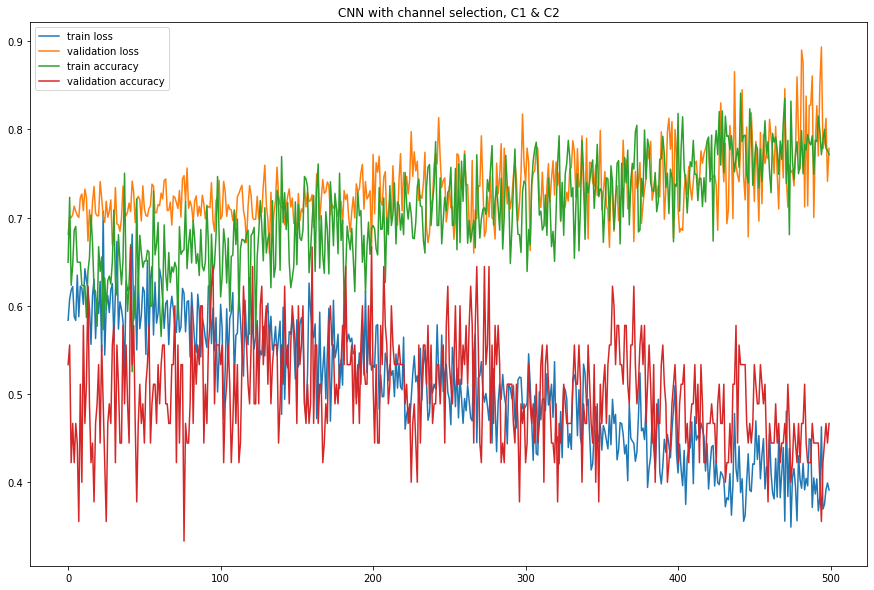

In [155]:
n_epochs = 500
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

for epoch in range(n_epochs):
    yhat, train_loss, train_acc = train_model(net, train_dataloader, optimizer, criterion)
    yhat, valid_loss, valid_acc = eval_model(net, valid_dataloader, optimizer, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)
    
    if (epoch) % 2 == 0:
        plot(train_losses, valid_losses, train_accuracy, valid_accuracy)


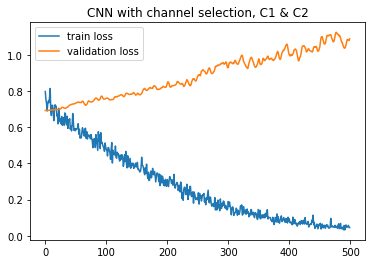

In [94]:
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='validation loss')
plt.title("CNN with channel selection, C1 & C2")
plt.legend()
plt.savefig("./results/CNN with channel selection, C1 & C2 - Loss curves Five Subjects.png", 
             bbox_inches='tight', transparent=True, dpi=100)
plt.show()

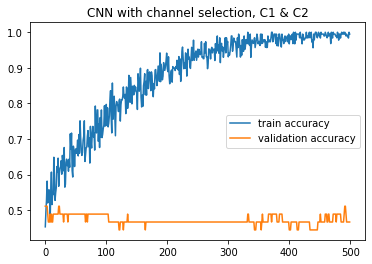

In [95]:
plt.plot(train_accuracy, label='train accuracy')
plt.plot(valid_accuracy, label='validation accuracy')
plt.title("CNN with channel selection, C1 & C2")
plt.legend()
plt.savefig("./results/CNN with channel selection, C1 & C2 - Accuracy with Five Subjects.png", 
             bbox_inches='tight', transparent=True, dpi=100)
plt.show()

### Prediction on the Test Dataset

In [60]:
items, labels = next(iter(test_dataloader))

In [61]:
items.requires_grad

True

In [66]:
yhat = net(items)
print(yhat.shape)
_,yhat = torch.max(yhat, dim=1)

print('Predictions:', yhat.data)
print('Accuracy: ', (torch.sum(yhat.squeeze()==labels)/labels.shape[0]).item())

x: torch.Size([22, 200, 4, 1])
torch.Size([22, 2])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1])
Accuracy:  0.40909090638160706


### Further Tasks

Given X and y, perform Binary Classification to correctly identify an event as T1 or T2. 

<p>T1 = Clenching Fists  (Real or imagining)</p>
T2 = Moving Feet      (Real or imagining)

**Possible methods which may be used:**
1. <s>Logistic Regression (Linearly separable data only)</s>
2. <s>State Vector Machines</s>
3. <s>Linear Discriminant Analysis</s>
4. CNN + LSTM

**We may also try Feature Engineering and Selection to improve accuracy of our model.**
1. Artifact Handling using ICA (may be better to let the deep learning model handle it)
2. <s>Common Spatial Patterns Algorithm to extract features</s>
3. <s>Using a subset of functionally-relevant Electrodes (channels)</s>
4. Applying Baseline to the training data to get less noisy signal
5. Short-time Fast Fourier Transform
6. Wavelet Transform